In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.1.0
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

Uninstalling tensorflow-1.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 450kB 57.9MB/s 
     |████████████████████████████████| 3.8MB 49.4MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Succes

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available() == True)

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from loaders import load_safari
from tensorflow.keras.utils import plot_model
import pandas as pd
from scipy.stats import norm
import pickle as pkl

In [0]:
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [0]:
(x_train, y_train) = load_safari(DATA_NAME)

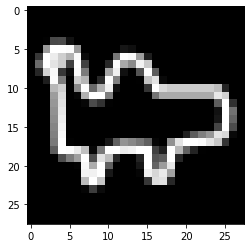

In [8]:
plt.imshow(x_train[200,:,:,0], cmap = 'gray')

In [0]:
class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = tf.keras.initializers.RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()

        self._build_adversarial()

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = tf.keras.layers.LeakyReLU(alpha = 0.2)
        else:
            layer = tf.keras.layers.Activation(activation)
        return layer

    def _build_discriminator(self):

        ### THE discriminator
        discriminator_input = tf.keras.layers.Input(shape=self.input_dim, name='discriminator_input')

        x = discriminator_input

        for i in range(self.n_layers_discriminator):

            x = tf.keras.layers.Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = tf.keras.layers.BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            x = self.get_activation(self.discriminator_activation)(x)

            if self.discriminator_dropout_rate:
                x = tf.keras.layers.Dropout(rate = self.discriminator_dropout_rate)(x)

        x = tf.keras.layers.Flatten()(x)
        
        discriminator_output = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)

        self.discriminator = tf.keras.Model(discriminator_input, discriminator_output)


    def _build_generator(self):

        ### THE generator

        generator_input = tf.keras.layers.Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = tf.keras.layers.Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)

        if self.generator_batch_norm_momentum:
            x = tf.keras.layers.BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = tf.keras.layers.Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = tf.keras.layers.Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = tf.keras.layers.UpSampling2D()(x)
                x = tf.keras.layers.Conv2D(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                )(x)
            else:

                x = tf.keras.layers.Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = tf.keras.layers.BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                    
                
            else:

                x = tf.keras.layers.Activation('tanh')(x)


        generator_output = x

        self.generator = tf.keras.Model(generator_input, generator_output)

       
    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = tf.keras.optimizers.Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = tf.keras.optimizers.RMSprop(lr=lr)
        else:
            opti = tf.keras.optimizers.Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE DISCRIMINATOR

        self.discriminator.compile(
        optimizer=self.get_opti(self.discriminator_learning_rate)  
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)

        model_input = tf.keras.layers.Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = tf.keras.Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate) , loss='binary_crossentropy', metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)

    def train_discriminator(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)

    def train(self, x_train, batch_size, epochs, run_folder
    , print_every_n_batches = 50
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)

            self.epoch += 1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.input_dim
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.z_dim
                ], f)

        self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        #pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))
        #케라스 모델은 피클이 되지 않음
        
    def load_weights(self, filepath):
        self.model.load_weights(filepath)  

In [0]:
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [11]:
gan.discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
discriminator_conv_0 (Conv2D (None, 14, 14, 64)        1664      
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
discriminator_conv_1 (Conv2D (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0     

In [12]:
gan.generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation_4 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
generator_conv_0 (Conv2D)    (None, 14, 14, 128)       2049

In [0]:
BATCH_SIZE = 64
EPOCHS = 3000
PRINT_EVERY_N_BATCHES = 5

In [14]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 [D loss: (0.727)(R 0.696, F 0.757)] [D acc: (0.195)(0.391, 0.000)] [G loss: 0.677] [G acc: 1.000]
1 [D loss: (0.727)(R 0.654, F 0.800)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.687] [G acc: 1.000]
2 [D loss: (0.640)(R 0.578, F 0.701)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.558] [G acc: 1.000]
3 [D loss: (0.369)(R 0.028, F 0.709)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.037] [G acc: 1.000]
4 [D loss: (2.530)(R 0.000, F 5.060)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.637] [G acc: 1.000]
5 [D loss: (0.784)(R 0.525, F 1.043)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.617] [G acc: 1.000]
6 [D loss: (0.770)(R 0.548, F 0.992)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.632] [G acc: 1.000]
7 [D loss: (0.727)(R 0.604, F 0.851)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.641] [G acc: 1.000]
8 [D loss: (0.708)(R 0.623, F 0.794)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.647] [G acc: 1.000]
9 [D loss: (0.704)(R 0.634, F 0.774)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.653] [G acc: 1.000]


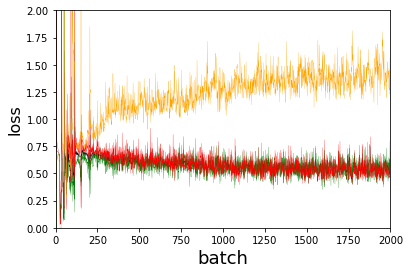

In [15]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
plt.ylim(0, 2)

plt.show()

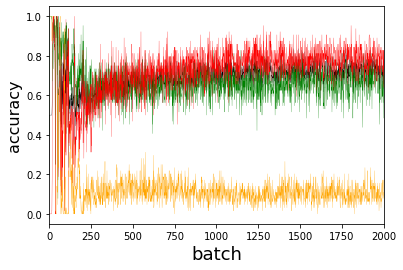

In [16]:
fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)

plt.xlim(0, 2000)

plt.show()